In [1]:
import time_series_transform as tst
import pandas as pd
import numpy as np
from time_series_transform.stock_transform.base import *
from time_series_transform.transform_core_api.time_series_transformer import *
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from time_series_transform.transform_core_api.util import *
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
import glob
stockList = []
for i in glob.glob('../Data/Train/sp500/*'):
    file  =i.replace('\\','/')
    stockList.append(tst.Stock(file.split('/')[-1],pd.read_csv(file)))
port = tst.Portfolio(stockList)

# Data Preproccessing

In [15]:
# port.remove_different_date()
df = port.get_portfolio_dataFrame()
df = df[['Date','Close','symbol']].dropna()
train = df[df.Date < '2019-06-01']
test = df[df.Date >= '2019-06-01']

In [20]:
def standardize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

In [21]:
train_ptst = Pandas_Time_Series_Tensor_Dataset(train)
time_series_col = train_ptst.expand_dataFrame_by_date('symbol','Date',byCategory = True)
trainX = train_ptst.df
trainX = trainX.dropna(axis =1)

In [22]:
trainX = trainX.apply(lambda x: standardize(x),axis =0)

In [23]:
test_ptst = Pandas_Time_Series_Tensor_Dataset(test)
time_series_col = test_ptst.expand_dataFrame_by_date('symbol','Date',byCategory = True)
testX = test_ptst.df
testX = testX.dropna(axis =1)

# Clustering

In [33]:
pca = TSNE()
db = DBSCAN(min_samples=2)

In [34]:
pc = pca.fit_transform(trainX)
cluster_num = db.fit_predict(pc)

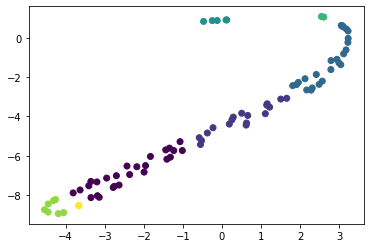

In [35]:
cluster = pd.DataFrame({'cluster':cluster_num,'pc1':pc[:,0],'pc2':pc[:,1]},index = trainX.index)
plt.scatter(cluster.pc1,cluster.pc2,c= cluster.cluster)
plt.show()

In [36]:
cluster_num

array([0, 1, 0, 1, 2, 3, 2, 0, 1, 2, 3, 0, 0, 0, 2, 2, 1, 1, 3, 1, 1, 2,
       1, 2, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0, 3, 2, 2, 1, 2, 0, 0, 4, 5, 0,
       5, 6, 1, 0, 1, 0, 5, 3, 0, 0, 0, 5, 5, 2, 2, 5, 1, 0, 1, 2, 2, 4,
       0, 1, 0, 2, 0, 5, 2, 1, 2, 2, 0, 0, 2, 2, 6, 0, 0, 2, 2],
      dtype=int64)

# Evaluation

In [37]:
def agg_day_return(arr,aggType):
    arr = arr.reshape((-1))
    numDay = len(arr)
    tmp = pd.DataFrame(arr,columns=['arr'])
    tmp['shift1'] = tmp.arr.shift(1)
    tmp = tmp.dropna()
    tmp['diff_col'] = tmp['arr']-tmp['shift1']
    return tmp.diff_col.agg(aggType)


In [38]:
def make_label(X,clusterNum):
    Y = pd.DataFrame()
    Y['std_return']=X.apply(lambda x:agg_day_return(x.values,'std'),axis =1)
    Y['avg_return']=X.apply(lambda x:agg_day_return(x.values,'mean'),axis =1)
    Y['min_return']=X.apply(lambda x:agg_day_return(x.values,'min'),axis =1)
    Y['max_return']=X.apply(lambda x:agg_day_return(x.values,'max'),axis =1)
    Y['sharpe'] = Y['avg_return']/Y['std_return']
    Y['mdd'] = (Y['min_return']-Y['max_return'])/Y['max_return']
    if clusterNum is not None:
        Y['cluster'] = clusterNum
        idx = Y.groupby(['cluster'])['sharpe'].transform(max) == Y['sharpe']
        return Y[idx]
    else:
        return Y

In [39]:
trainY = make_label(trainX,cluster_num)
testY = make_label(testX,None)

In [40]:
testY.loc[trainY.index]

,std_return,avg_return,min_return,max_return,sharpe,mdd
symbol,,,,,,
AIG.csv,NaN,NaN,NaN,NaN,NaN,NaN
AMZN.csv,NaN,NaN,NaN,NaN,NaN,NaN
LDOS.csv,NaN,NaN,NaN,NaN,NaN,NaN
TDY.csv,NaN,NaN,NaN,NaN,NaN,NaN
UA.csv,NaN,NaN,NaN,NaN,NaN,NaN
VRSK.csv,NaN,NaN,NaN,NaN,NaN,NaN
WY.csv,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
seleted = testY.loc[trainY.index][['sharpe','mdd','avg_return']].agg(['mean'])
other = testY.loc[testY.index.drop(trainY.index)][['sharpe','mdd','avg_return']].agg(['mean'])

In [42]:
seleted

,sharpe,mdd,avg_return
mean,NaN,NaN,NaN


In [43]:
other

,sharpe,mdd,avg_return
mean,NaN,NaN,NaN


In [44]:
 testY.loc[trainY.index].sort_values('avg_return',ascending=False)

,std_return,avg_return,min_return,max_return,sharpe,mdd
symbol,,,,,,
AIG.csv,NaN,NaN,NaN,NaN,NaN,NaN
AMZN.csv,NaN,NaN,NaN,NaN,NaN,NaN
LDOS.csv,NaN,NaN,NaN,NaN,NaN,NaN
TDY.csv,NaN,NaN,NaN,NaN,NaN,NaN
UA.csv,NaN,NaN,NaN,NaN,NaN,NaN
VRSK.csv,NaN,NaN,NaN,NaN,NaN,NaN
WY.csv,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
testY.loc[testY.index.drop(trainY.index)].sort_values('avg_return',ascending=False)

,std_return,avg_return,min_return,max_return,sharpe,mdd
symbol,,,,,,
AAL.csv,NaN,NaN,NaN,NaN,NaN,NaN
ABC.csv,NaN,NaN,NaN,NaN,NaN,NaN
AME.csv,NaN,NaN,NaN,NaN,NaN,NaN
AMGN.csv,NaN,NaN,NaN,NaN,NaN,NaN
ANSS.csv,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
WMT.csv,NaN,NaN,NaN,NaN,NaN,NaN
XEL.csv,NaN,NaN,NaN,NaN,NaN,NaN
XRAY.csv,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
make_label(trainX,None)

,std_return,avg_return,min_return,max_return,sharpe,mdd
symbol,,,,,,
AAL.csv,0.002291,-6.643112e-05,-0.005383,0.004083,-2.899355e-02,-2.318423
ABC.csv,0.004892,5.531381e-05,-0.016903,0.013097,1.130677e-02,-2.290595
AIG.csv,0.002458,7.164712e-04,-0.002587,0.014174,2.915322e-01,-1.182499
AME.csv,0.001789,1.898771e-04,-0.004240,0.004477,1.061090e-01,-1.946971
AMGN.csv,0.005947,-1.274624e-03,-0.020429,0.013469,-2.143386e-01,-2.516735
...,...,...,...,...,...,...
WY.csv,0.002033,3.565419e-12,-0.003980,0.006370,1.753963e-09,-1.624752
XEL.csv,0.002428,2.094055e-04,-0.004736,0.006506,8.625920e-02,-1.727979
XRAY.csv,0.002344,4.602692e-04,-0.003863,0.012462,1.963321e-01,-1.310013
